In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
import seaborn as sns 

import statsmodels.api as sm
sns.set()


from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
import xgboost as xgb


import reproduction
import marie
import regressions

%load_ext autoreload
%autoreload 2



from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

# Plots function

import the data

In [2]:
y1, y2, y3, y4, X, realization = regressions.data_initialization(realiz=True)

In [77]:
y3.name

'k2_bwd_effective'

split the data

In [3]:
Y = np.column_stack((y1, y1, y3, y4))

X = X.drop(columns=['sigma_mass_0.0', 'sigma_mass_0.825', 'enzyme_concentration'])
X_panda = X.copy()
X = X.values


X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.4)
print(X_train.shape, X_test.shape)
y1_train, y1_test = y1_train.values, y1_test.values

(91173, 5) (60783, 5)


In [4]:
X_panda.head()

,enzyme_complex_concentration,mu_mass,product_concentration,substrate_concentration,volume_fraction
0,-9.761988,12.1,-9.230543,-9.923690,0.2
1,-11.959213,12.1,-8.825078,-8.314252,0.2
2,-10.860600,31.9,-11.022305,-10.616837,0.2
3,-11.266065,12.1,-8.537396,-11.309985,0.4
4,-11.959213,12.1,-9.923690,-8.825078,0.2


Train Xgboost

In [5]:
param = {'max_depth': 10, 'eta': 1, 'silent': 1, 'subsample': 0.8}
# param['nthread'] = 4
param['reg_alpha'] = 0.7
# param['reg_lamda'] = 0.5
param['tree_method'] = 'auto'

dtrain1 = xgb.DMatrix(X_train, label=y1_train)
dtest = xgb.DMatrix(X_test)

xgbReg = xgb.train(params=param, dtrain=dtrain1)

y1_pred_tr = xgbReg.predict(dtrain1)
y1_pred_te = xgbReg.predict(dtest)

Score and importance of the covariates

Train R^2 score :  0.9998406910739529 
 Test R^2 score :  0.9998361102522368
MSE on train :  0.0001768603042120485 
 MSE on test :  0.0001834421873210494


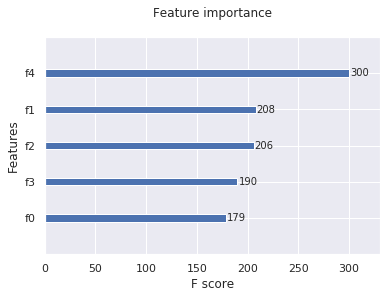

In [7]:
print('Train R^2 score : ', explained_variance_score(y1_train, y1_pred_tr), '\n',
     'Test R^2 score : ', explained_variance_score(y1_test, y1_pred_te))

print('MSE on train : ', mean_squared_error(y1_train, y1_pred_tr), '\n',
     'MSE on test : ', mean_squared_error(y1_test, y1_pred_te))

xgb.plot_importance(xgbReg)

## Tries for a plot function

In [8]:
pd.DataFrame(X_train).head()

,0,1,2,3,4
0,-10.860600,21.1,-10.616837,-9.230543,0.3
1,-10.860600,36.8,-8.537396,-9.923690,0.2
2,-9.761988,12.1,-8.314252,-9.230543,0.4
3,-10.349775,21.1,-9.923690,-11.309985,0.5
4,-11.266065,21.1,-8.314252,-9.923690,0.1


In [9]:
data = np.random.rand(7, 5)
dtest = xgb.DMatrix(data)
ypred = xgbReg.predict(dtest)

In [10]:
ypred

array([ 1.9579071, -1.4340743, -1.4340743, -0.5274495, -0.5274495,
        0.6516718, -0.5274495], dtype=float32)

 ## constants for the plots functions to work

In [11]:
# theoritical constants from the chemistry point of view
E_tot = 64e-6
P0 = 49e-6
S0 = 49e-6
E0 = 0.5*E_tot
ES0 = 0.5*E_tot

In [12]:
# heuristic for the xgboost model
P0 = np.median(X_panda.product_concentration.values)
S0 = np.median(X_panda.substrate_concentration.values)
ES0 = np.median(X_panda.enzyme_complex_concentration.values)
mu0 = np.median(X_panda.mu_mass.values)
v0 = 0.3

In [67]:
param = {'max_depth': 10, 'eta': 1, 'silent': 1, 'subsample': 0.8}
# param['nthread'] = 4
param['reg_alpha'] = 0.7
# param['reg_lamda'] = 0.5
param['tree_method'] = 'auto'

dtrain1 = xgb.DMatrix(X_train, label=y1_train)
dtest = xgb.DMatrix(X_test)

xgbReg = xgb.train(params=param, dtrain=dtrain1)

y1_pred_tr = xgbReg.predict(dtrain1)
y1_pred_te = xgbReg.predict(dtest)

In [64]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

model = xgbReg

def compute_mesh_values(x = arange(-13,-6,0.01),y = arange(-13,-6,0.01),
                        base = np.array([ES0,mu0,P0,S0,v0]),covariates = ['P','S'],model = xgbReg):

    # the function that I'm going to plot
    def z_func(x,y):

        ES_ref = np.repeat(base[0],len(x))
        P_ref = np.repeat(base[2],len(x))
        mu_ref = np.repeat(base[1],len(x))
        v_ref = np.repeat(base[4],len(x))
        S_ref = np.repeat(base[3],len(x))

#---------------------------------------------------------------------------------------------
# choose the plot with the right axes

        if covariates == ['P','S']:
            predict_on = np.array([ES_ref,mu_ref,x,y,v_ref])
        elif covariates == ['S','P']:
            predict_on = np.array([ES_ref,mu_ref,y,x,v_ref])
        
        elif covariates == ['ES','P']: 
            predict_on = np.array([x,mu_ref,y,S_ref,v_ref])
        elif covariates == ['P','ES'] :
            predict_on = np.array([y,mu_ref,x,S_ref,v_ref])
            
        
        elif covariates == ['ES','S'] :
            predict_on = np.array([x,mu_ref,P_ref,y,v_ref])
        elif covariates == ['S','ES']:
            predict_on = np.array([y,mu_ref,P_ref,x,v_ref])
        else: 
            raise Exception('combinaison not implemented')
        
#----------------------------------------------------------------------------------------------
        
        
        
        dtest = xgb.DMatrix(np.matrix.transpose(predict_on))
        result = model.predict(dtest)
        return result                           


    def Z_FUNC(X,Y):
        x = np.array([(x, y) for x in X for y in Y])
        result = z_func(x[:,0],x[:,1]).reshape(len(X),len(Y))
        return result

    X,Y = meshgrid(x, y) # grid of point

    Z = Z_FUNC(x, y) # evaluation of the function on the grid
    
    return Z

In [65]:
def plot_evolution(x = arange(-13,-6,0.01),y = arange(-13,-6,0.01),
                   base = np.array([ES0,mu0,P0,S0,v0]), covariates = ['P','S'], model = xgbReg):
    
    Z = compute_mesh_values(x,y,base,covariates, model)

    im = imshow(np.transpose(Z),cmap=cm.RdBu) # drawing the function
    # adding the Contour lines with labels
    #cset = contour(np.transpose(Z),arange(-2,2,0.1),linewidths=2,cmap=cm.Set2)
    #clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    colorbar(im) # adding the colobar on the right

    ax = plt.gca()
    ax.set_xticks(np.arange(0,len(x),len(x)/3))
    ax.set_yticks(np.arange(0, len(x), len(x)/3))
    ax.set_xticklabels([x[0],round(x[int(len(x)/3)],2),round(x[int(2*len(x)/3)],2)])
    ax.set_yticklabels([y[0],round(y[int(len(x)/3)],2),round(y[int(2*len(x)/3)],2)])
    plt.xlabel(covariates[0])
    plt.ylabel(covariates[1])

    plt.title("evolution of log(k1_backward) wrt to [" + covariates[0] + '] and [' + covariates[1] +']' )
    plt.savefig('../results/plots_evolution/volume'+str(base[-1])+'/y1_' +covariates[0]
                +'_'+ covariates[1]+'.pdf', bbox_inches='tight')
    plt.show()

In [72]:
def plot_evolution_model(model_parameters = param, dtrain1 = dtrain1 ):
        
    #xgbReg = xgb.train(params=model_parameters, dtrain=dtrain1)

    
    volumes = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])
    concentrations = ['ES','P','S']

    base = np.array([ES0,mu0,P0,S0,v0])

    for v in volumes :
        base[-1] = v
        done = []
        for i,c1 in enumerate(concentrations):
            for c2 in np.delete(concentrations,i):
                candidats = [c1,c2]
                if candidats not in done:
                    done.append(candidats)
                    done.append([c2,c1])
                    plot_evolution(base = base, covariates = [c1, c2])#, model = xgbReg)
                else : 
                    print("combinaison already done: ",c1, " ",c2)

            


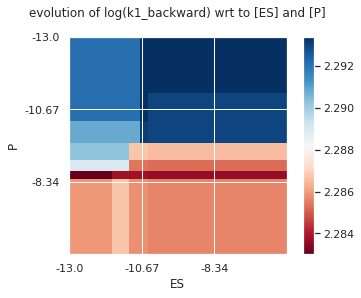

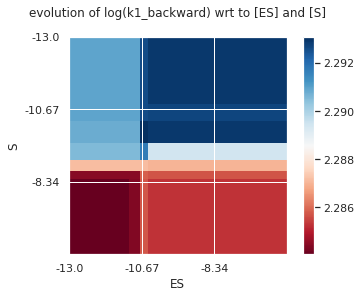

combinaison already done:  P   ES


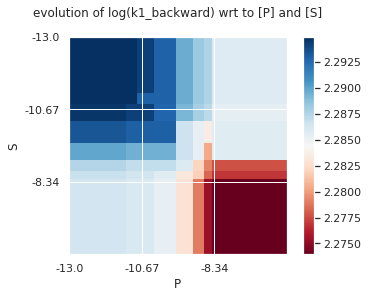

combinaison already done:  S   ES
combinaison already done:  S   P


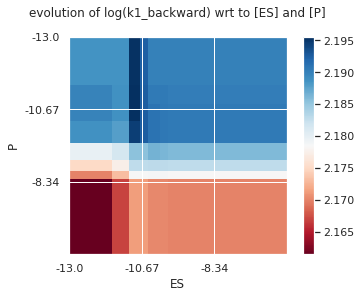

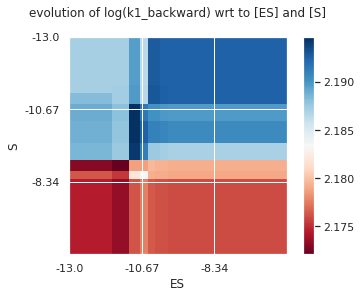

combinaison already done:  P   ES


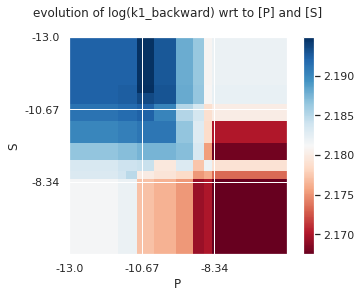

combinaison already done:  S   ES
combinaison already done:  S   P


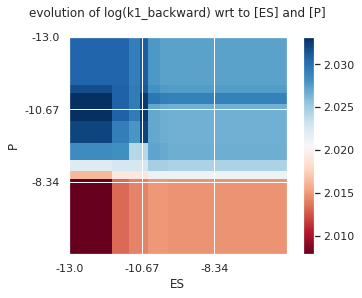

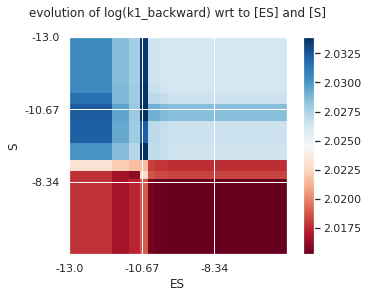

combinaison already done:  P   ES


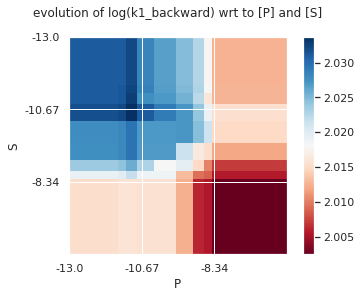

combinaison already done:  S   ES
combinaison already done:  S   P


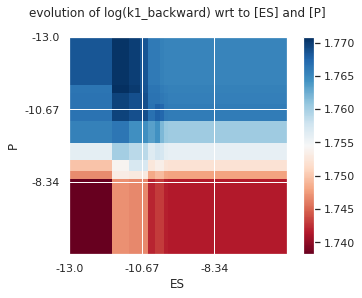

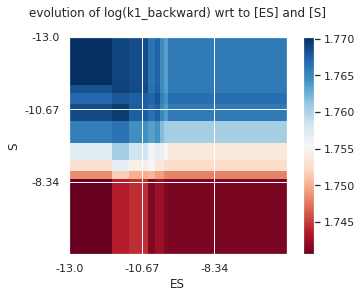

combinaison already done:  P   ES


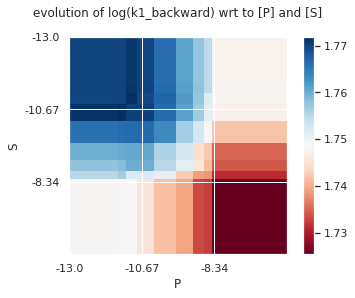

combinaison already done:  S   ES
combinaison already done:  S   P


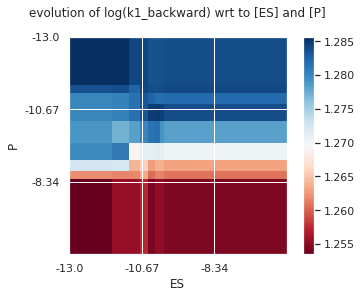

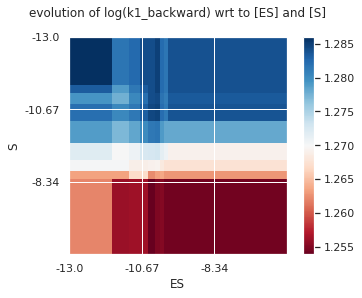

combinaison already done:  P   ES


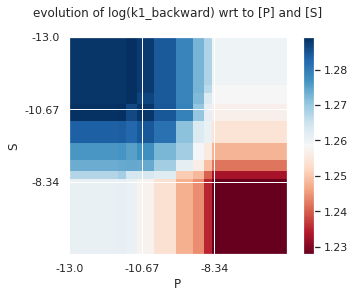

combinaison already done:  S   ES
combinaison already done:  S   P


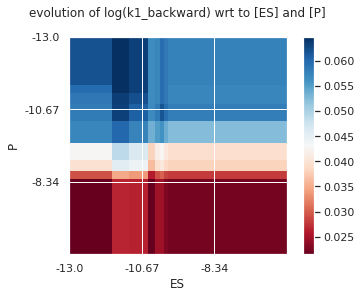

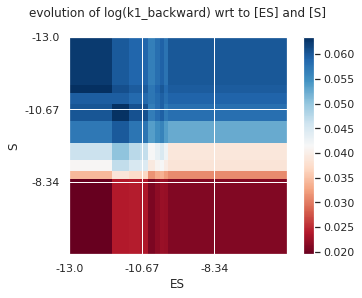

combinaison already done:  P   ES


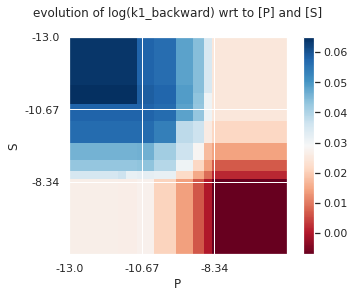

combinaison already done:  S   ES
combinaison already done:  S   P


In [73]:
plot_evolution_model()

In [ ]:
Z_star = Z.reshape(Z.shape[0]*Z.shape[1])
print("Z done")
y_star = y1[(X_panda["enzyme_complex_concentration"] == ES0) &
                (X_panda["mu_mass"] == mu0) & 
                (X_panda["volume_fraction"] ==v0)]
print("y_star done")
visualisation = pd.DataFrame(Z_star)
print(visualisation.describe())
print(" ")
print(y_star.describe())

In [ ]:
y1.describe()

In [ ]:
dtest = xgb.DMatrix(X_train[0:2,:])
ypred = xgbReg.predict(dtest)
error = ypred - y1_train[0:2]
plt.hist(error, bins = 1000)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [ ]:
test = np.array([ES0,mu0,P0,S0,v0])
print(test)

In [ ]:
print(X_train[0:2,:])
print(ypred)
print(y1_train[0:2])

In [ ]:
print(xgbReg.predict(xgb.DMatrix(np.array(([test,test])))))

In [ ]:
X_visu = pd.DataFrame(X_train)
X_visu = X_visu.rename(columns={0: "ES", 1: "mu", 2:"P",3:"S",4:"v"})
X_visu.head()

In [ ]:
y1_train[(X_visu["ES"] == test[0]) & (X_visu["mu"]==test[1]) & (X_visu["P"]==test[2]) & (X_visu["S"]==test[3])
      & (X_visu["v"]==test[4])]

the values below will gives us the bound to do our plots

In [ ]:
pd.DataFrame(X_test).describe()

## From doc skilearn

In [ ]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


h = .02  # step size in the mesh

names = ["AdaBoost"]

classifiers = [AdaBoostClassifier()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1 
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')


        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        i += 1

plt.tight_layout()
plt.show()


# Neural networks

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


##3 have to upgrade the version of h5py otherwise the kernel dies ! use 'pip install h5py==2.8.0' 

In [ ]:
y1, y2, y3, y4, X, realization = william.data_initialization(realiz=True)

Y = np.column_stack((y1, y1, y3, y4))

X_train, X_test, y_train, y_test = william.train_test_split_realiz(X, Y,realization ,test_size=0.3)

train_data = X_train
train_labels = y_train[:,1]

test_data = X_test
test_labels = y_test[:,1]

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()


In [ ]:
model = build_model()

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 0.6])

plot_history(history)


In [ ]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions, s =1, alpha = 1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 500)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")


In [ ]:
np.mean(error*error)

# Definition of the data vizualization functions

here we aim to plot the predicted value with its confidence interval 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.cos(x)/(np.sin(x)+1.1)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
#plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
#plt.fill(np.concatenate([xx, xx[::-1]]),np.concatenate([y_upper, y_lower[::-1]]),alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

# Loading the data

In [ ]:
import run_reproduction

In [ ]:
file = "../Data/result_full_factorial_pgm.csv"

In [ ]:
data = run_reproduction.Data_prep_replication(file)

In [ ]:
weights = run_reproduction.weights_obtain(data)

In [ ]:
results = run_reproduction.regression_results(data)

In [ ]:
results.head()

X = data.loc[:, data.columns != '']
X_train, X_test, y_train, y_test = train_test_split(X, y1, random_state=0, test_size=0.4)
print(X_train.shape, X_test.shape)

In [ ]:
marie.regression_results(data)

In [ ]:
#we look for a crowding condition of 10%
test = data[(data['volume_fraction']==0.1)]

test = test[(test['sigma_mass'] == 0.825)]
test = test[(test['mu_mass']== 31.9)]
Weights = charles.weights_obtain(test)

In [ ]:
Weights.head()

## Notation

y1 = log_k1_bwd

y2 = log_k1_fwd

y3 = log_k2_bwd

y4 = log_k2_fwd

In [ ]:
# build the model matrix
X = test[['E','ES','P','S']]
X = sm.add_constant(X)

In [ ]:
X.head()

In [ ]:
model_y1 = sm.WLS(test['log_k1_bwd'],X, weights=Weights.log_k1_bwd).fit()
model_y2 = sm.WLS(test['log_k1_fwd'],X, weights=Weights.log_k1_fwd).fit()
model_y3 = sm.WLS(test['log_k2_bwd'],X, weights=Weights.log_k2_bwd).fit()
model_y4 = sm.WLS(test['log_k2_fwd'],X, weights=Weights.log_k2_fwd).fit()

In [ ]:
print(model_y1.summary())
print(model_y2.summary())
print(model_y3.summary())
print(model_y4.summary())

In [ ]:
print(model_y1.rsquared_adj)

In [ ]:
models = [model_y1,model_y2,model_y3,model_y4]
for m in models:
    print(m.mse_total)

In [ ]:
R,M = charles.obtain_measure_goodness_of_fit_reproduction()

In [ ]:
# name = 'log_k2_fwd'
print(R[name])
print(" ")
print(M[name])


In [ ]:
M

In [ ]:
R

In [ ]:
file_results = '../results/reproduction.csv'

In [ ]:
results = pd.read_csv(file_results)

In [ ]:
results

we want to plot the evolution of the different coefficients wrt to the evolution of the volume fraction 

In [ ]:
results['Median of the Massdistribution in kDa'].unique()

In [ ]:
data_of_interest = results[(results['Rate constant']== 'k1_bwd') & (results['Median of the Massdistribution in kDa'] < 21)]

intercept_k1_bwd = data_of_interest.beta.values.astype(np.float)
alpha_E_k1_bwd = data_of_interest['alpha E'].values.astype(np.float)
alpha_E_k1_bwd_below = data_of_interest['alpha E.1'].values.astype(np.float)
alpha_E_k1_bwd_above = data_of_interest['alpha E.2'].values.astype(np.float)

alpha_ES_k1_bwd = data_of_interest['alpha ES'].values.astype(np.float)
alpha_P_k1_bwd = data_of_interest['alpha P'].values.astype(np.float)
alpha_S_k1_bwd = data_of_interest['alpha S'].values.astype(np.float)
volume_frac = data_of_interest['Volume fraction'].values.astype(np.float)

In [ ]:
plt.plot(volume_frac,alpha_E_k1_bwd)
plt.plot(volume_frac,alpha_E_k1_bwd_below)
plt.plot(volume_frac,alpha_E_k1_bwd_above)
plt.xlabel("volume fraction")
plt.ylabel("alpha E")
plt.title("for k1_bwd")

In [ ]:
ax = sns.lineplot(volume_frac,alpha_E_k1_bwd)
ax = sns.lineplot(volume_frac, alpha_E_k1_bwd_above)

In [ ]:
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="timepoint", y="signal", data=fmri)


#  <span style="color:red"> *Garbage, don't look* </span>.

# From the paper, theory

Linear regression to estimate $\beta$ and $\alpha_j$ in the following model:

\begin{equation*}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \alpha_{E,j}log(\frac{[E]}{[E]_0}) + \alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \alpha_{P,j}log(\frac{[P]}{[P]_0})  + \alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation*}

where $j\in [1_{bwd}, 1_{fwd}, 2_{bwd}, 2_{fwd}]$,

$k$ is the effective rate constant, and $k_0$ is the relative rate constant


basically the log ration of the concentration only depends on the volume fraction, the sigma mass and the mu mass: we don't need the covariate [E], [S], [ES], [P] and we can predict exactly the results

form the code of the paper

In [ ]:
X = data[['E','ES','P','S']]
Y = data.log_k1_bwd

X = sm.add_constant(X)

In [ ]:
model = LinearRegression()
model.fit(X,Y)
res = (Y-model.predict(X)).values

In [ ]:
model2 = sm.OLS(X,Y).fit()
res2 = sm.OLS(X,Y).fit().resid

In [ ]:
res2

In [ ]:
import numpy as np
import statsmodels.api as sm
data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog)
ols_resid = sm.OLS(data.endog, data.exog).fit().resid
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [ ]:
ols_resid

# Computation of the residuals   

### note

We have to do this for each "group" define by a combination of values of `sigma_mass`, `mu_mass` and `volume_occupation`

following the paper process we compute regression like the following one : 


`log_k_j` = $\beta + \alpha_1$ `E` + $r_E$

and then compute an estimate of the variance: 

$\sqrt{\frac{RSS}{n-2}}$  where RSS = $|| r_E||_2^2$

In [ ]:
#create dataframe to do the regression
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [ ]:
#do the regression and return the model fitted
def regression(X,y):
    reg = LinearRegression()
    reg.fit(X,y)
    
    y_hat = reg.predict(X)
    coeffs = reg.coef_
    residuals = (y-y_hat).values
    return coeffs,y_hat,residuals

In [ ]:
mus = data.mu_mass.unique()
sigmas = data.sigma_mass.unique()
volumes = [0.1,0.2,0.3,0.4,0.5]

names = ["E","ES","P","S"]

In [ ]:
def Regressors(data):
    '''
    return a vector containing the design matrix for the regression of the log efficient rate ratio against 
    E,ES,P,S in that order
    '''
    X_total = []
    for name in names:
        X_total.append(create_regressors(data,name))
    return X_total

In [ ]:
#combination done into the paper
combinations = [[31.9,0.825],[12.1,0],[21.1,0],[36.8,0]]

we do the regression oonly for `log_k1_backward`

In [ ]:
results = []

for volume in volumes:
    for comb in combinations:
        mu = comb[0]
        sigma =comb[1]
        #take data wth corresponding values in mu, sigma and volume fraction
        data_tested = data_trans[(data_trans['volume_fraction']== volume) & (data_trans['sigma_mass'] == sigma) 
                                         & (data_trans['mu_mass'] == mu)]
        
        
        #build regression matrices
        X_total = Regressors(data_tested)
        y = data_tested.log_k1_bwd
        
        #storage for the model
        #do the regression for each individual regressor (E,ES,P,S)
        for i,X in enumerate(X_total):
            c,y_,r = regression(X,y)
            results.append([volume,mu,sigma,names[i],c,y_,r])


In [ ]:
results =  pd.DataFrame(results)
results.columns = ["volume fraction","mu mass","sigma mass","regressor","coefficients","fitted values","residuals"]
results.head()

Now for each of the possible model, we compute the estimated variance of the residuals 

In [ ]:
def estimate_variance(residuals):
    '''
    compute an estimate of the variance of the residuals of the residuals of a simple model with intercept + one covariate
    '''
    
    return np.sqrt(residuals.T@residuals/(len(residuals)-2)) 

In [ ]:
variances = []
for elt in results.residuals:
    variances.append(estimate_variance(elt))

results['variance'] = variances

In [ ]:
results.head()

from the paper, we now have that the variances we just computed can be used as weights in the following weighted linear regression:


\begin{equation}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \frac{1}{w_{E,j}}\alpha_{E,j}log(\frac{[E]}{[E]_0}) + \frac{1}{w_{ES,j}}\alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \frac{1}{w_{P,j}}\alpha_{P,j}log(\frac{[P]}{[P]_0})  + \frac{1}{w_{S,j}}\alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation}


for example for the regression with crowding condition of  10% `volume_fraction`= 0.1, $\sigma$ = 0,825 `sigma_mass`, $\mu$ = 31,9 `mu_mass`

from the paper we obtain the follwing results: 


| rate constant | beta         | alpha E     | alpha ES             | alpha P              | alpha S               |
|---------------|--------------|-------------|----------------------|----------------------|-----------------------|
| k1_bwd        | -0,117350672 | 0,001708119 | 0,00345717778022485  | -0,00357500867782065 | -0,00356439766610846  |
| k1_fwd        | 0,261382491  | 0,019792839 | 0,0134094988545651   | 0,00251142064461377  | -0,000113387322631445 |
| k2_bwd        | 0,254376425  | 0,003928231 | -0,00280085370093718 | 0,00275505219650836  | 0,000116286746598914  |
| k2_fwd        | -0,117347247 | 0,001710861 | 0,0034597304524437   | -0,00357523318543554 | -0,00356439549439028  |

we select from the data we computed beforeonly the relevant part 

In [ ]:
interest = results[(results['volume fraction'] == 0.1) & (results['sigma mass']== 0.825) & (results['mu mass']==31.9)]
interest.head()

In [ ]:
#we now define the weights: 
weights  = interest.variance.values
[wE,wES,wP,wS]=1/weights


#we first take the subset of the data that corresponds to our case (V = 0.1, sigma = 0.825, mu = 31.9)
data_interest = data_trans[(data_trans['volume_fraction'] == 0.1) & (data_trans['sigma_mass']== 0.825) &
                           (data_trans['mu_mass']==31.9)]

#we compute our design matrix
X_interest = create_regressors(data_interest,["E",'ES','P','S'])

#we then modify with our weights in order to do the weigthed linear regression 
X_interest *= [1,wE,wES,wP,wS]

#we then do the regression for all four responses
y1 = data_interest.log_k1_bwd
y2 = data_interest.log_k1_fwd
y3 = data_interest.log_k2_bwd
y4 = data_interest.log_k2_fwd
 
Y = [y1,y2,y3,y4]

for i,y_int in enumerate(Y):
    model = LinearRegression()
    model.fit(X_interest,y_int)
    coeff = model.coef_
    print("model for y_",i,": ")
    print("coefficients for the models, beta, alpha E, alpha ES, alpha P, alpha S")
    print(coeff*[1,wE,wES,wP,wS])

#### note

here we computed approximation for all four covariates, but we only computed the weights for `log_k1_bwd`, so it is the only computation which is really valuable, but still the results are very different

In [ ]:
print(len(results.variance.unique()))
print(len(results['volume fraction'].unique()))

# Test the reproducibility

### for $log\left(\frac{k_{1,\text{forward,eff}}}{k_{1,\text{forward,relative}}}\right)$, using volume fraction  = $0.0$

In [ ]:
# select data corresponding to our case
data_test = data_trans[data_trans['volume_fraction']==0.0]

#define the y for the regression
y = data_test["log_k1_fwd"]

#define the features we will regress on
x = data_test[['E', 'ES', 'P', 'S']].values
X = X = np.c_[np.ones(len(x)), x] #add intercept

In [ ]:
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [ ]:
data_test.size

from the paper, we excpect to have the following result: 

$\beta = 7.31e-2$

$\alpha = [4.74e-3,1.07e-2,-,-]$ for the following features: S, E, ES, P

#### residuals computed from regression with all the features 

first we compute a regular linear regression in order to estimate the conitionnal variance of the residuals:

In [ ]:
#fit linear model
reg = LinearRegression()
X_E = create_regressors(data_test,['E','ES','P','S'])
reg.fit(X_E,y)

#get the fitted values
y_hat = reg.predict(X_E)
residuals = (y-y_hat).values

#compute the residuals

In [ ]:
plt.plot(y_hat,residuals/y)
plt.show()

In [ ]:
plt.scatter(y = y, x = data_test['E'].values)
plt.plot(data_test['E'].values, y_hat,color='red')
plt.show()

since s = RSS: 

In [ ]:
weight_estimate = np.sqrt(np.var(residuals)/(X_E.size -2))

In [ ]:
data_test_weighted = data_test.copy()
data_test_weighted['E'] =  data_trans['E']/weight_estimate
data_test_weighted['ES'] = data_trans['ES']/weight_estimate
data_test_weighted['P'] =  data_trans['P']/weight_estimate
data_test_weighted['S'] =  data_trans['S']/weight_estimate
data_test_weighted.describe()

In [ ]:
data_test_weighted

In [ ]:
reg = LinearRegression()
X = create_regressors(data_test_weighted,['E','ES','P','S'])
reg.fit(X,y)

print(reg.coef_)


#### residuals computed for each feature individually

In [ ]:
def estimate_weight(data,covariate):
    
    y = data["log_k1_bwd"]
    #regression only with a certain feature covariate
    reg = LinearRegression()
    X = create_regressors(data,covariate)
    reg.fit(X,y)

    #find the residuals
    y_hat = reg.predict(X)
    residuals = (y-y_hat).values

    #computation of the weight
    weight_estimate = np.sqrt(np.var(residuals)/(X.size -2))
    
    return weight_estimate

In [ ]:
covariates = ['E','S','ES','P']
weights = []

for name in covariates:
    weights.append(estimate_weight(data_test,name))

In [ ]:
print(weights)

we obtain the same weight for the different covariates

In [ ]:
# count the different type of volume occupation
vfraction = data['volume_fraction'].values
unique = np.unique(vfraction)

In [ ]:
Weight = []
for volume in unique:
    w = []
    data = data_trans[data_trans['volume_fraction']==volume]
    for name in covariates:
        w.append(estimate_weight(data_test,name))
    Weight.append(w)
    print(w)

In [ ]:
tab_weights2 = pd.DataFrame(Weight)

tab_weights[0].values[0]

In [ ]:
tab_weights2[0].values[0]

issue : same weight for all types of concentration

but it is still different for the different coefficient we are trying to estimate:

for y1_forward : 2.4322071957924314e-18

for y1_backward: 1.529293643074293e-18

let's try to do a weigthed regression with these weights:

In [ ]:
reg = LinearRegression()

data_test_weighted = data_trans.copy()
data_test_weighted['E'] =  data_trans['E']/1.529293643074293e-18
data_test_weighted['ES'] = data_trans['ES']/1.529293643074293e-18
data_test_weighted['P'] =  data_trans['P']/1.529293643074293e-18
data_test_weighted['S'] =  data_trans['S']/1.529293643074293e-18


D = data_test_weighted[data_test_weighted["volume_fraction"]==0.2]
X = create_regressors(D,covariates)
y = D["log_k1_bwd"]

reg.fit(X,y)

reg.coef_

In [ ]:
reg.coef_/1.529293643074293e-18

In [ ]:
w = 1#.529293643074293e-18

mod_wls = sm.WLS(y, X, weights=1./(w))
res_wls = mod_wls.fit()
print(res_wls.summary())